### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
 !pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 36.0 MB/s eta 0:00:00


In [4]:
import sklearn
import tensorflow as tf
from transformers import TFTrainer, TFTrainingArguments, TFRobertaForSequenceClassification
from transformers import RobertaTokenizerFast, RobertaModel
from sklearn.model_selection import train_test_split

### Initializing the tokenizer and the pretrained Roberta model

In [5]:
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')
model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=5)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Loading and preprocessing the data

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Emotion Recognition/Dataset/data.csv')

In [7]:
df = df[df['Label'] != 2]
df['Label'] = df['Label'].map({0:0, 1:1, 3:2, 4:3, 5:4})

In [8]:
df.columns = ['text', 'label']

In [9]:
df['label'].value_counts()

1    141067
0    121187
2     57317
3     47712
4     14972
Name: label, dtype: int64

In [10]:
train_split = int(len(df) * 0.8)
val_split = int(len(df) * 0.9)

In [11]:
train_df = df[:train_split]
eval_df = df[train_split:val_split]
test_df = df[val_split:]

In [12]:
train_df.dropna(inplace=True)
eval_df.dropna(inplace=True)
test_df.dropna(inplace=True)

<ipython-input-12-91c19d78f0b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.dropna(inplace=True)
<ipython-input-12-91c19d78f0b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df.dropna(inplace=True)
<ipython-input-12-91c19d78f0b5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.dropna(inplace=True)


In [13]:
train_df.info()
print()
test_df.info()
print()
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305804 entries, 0 to 333340
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    305804 non-null  object
 1   label   305804 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.0+ MB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38226 entries, 375055 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    38226 non-null  object
 1   label   38226 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 895.9+ KB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38225 entries, 333341 to 375054
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    38225 non-null  object
 1   label   38225 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 895.9+ KB


In [14]:
train_df

,text,label
0,i feel awful about it too because it s my job ...,0
1,im alone i feel awful,0
2,ive probably mentioned this before but i reall...,1
3,i was feeling a little low few days back,0
6,i am one of those people who feels like going ...,1
...,...,...
333335,i allow her to share special moments with a gr...,2
333336,i feel called to this work and because i am pa...,1
333337,i feel anger when you describe to me in detail...,0
333339,i guess but i feel so stupid for being lured i...,0


In [15]:
X_train = train_df['text'].tolist()
y_train = train_df['label'].tolist()

In [16]:
X_eval = eval_df['text'].tolist()
y_eval = eval_df['label'].tolist()

In [17]:
X_test = test_df['text'].tolist()
y_test = test_df['label'].tolist()

In [20]:
# train_encodings = tokenizer(X_train, truncation=True, padding=True, return_tensors='tf')
# eval_encodings = tokenizer(X_eval, truncation=True, padding=True, return_tensors='tf')
test_encodings = tokenizer(X_test, truncation=True, padding=True, return_tensors='tf')

In [ ]:
train_labels = tf.keras.utils.to_categorical(y_train, num_classes=5)
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)).batch(32)

In [ ]:
eval_labels = tf.keras.utils.to_categorical(y_eval, num_classes=5)
eval_dataset = tf.data.Dataset.from_tensor_slices((dict(eval_encodings), eval_labels)).batch(32)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.fit(train_dataset, epochs=1)

 145/9557 [..............................] - ETA: 1:51:34 - loss: 0.8843 - accuracy: 0.6728

KeyboardInterrupt: ignored

In [ ]:
model.save_pretrained('/content/drive/MyDrive/Colab Notebooks/Emotion Recognition/roberta')
tokenizer.save_pretrained('/content/drive/MyDrive/Colab Notebooks/Emotion Recognition/roberta')

('/content/drive/MyDrive/Colab Notebooks/Emotion Recognition/roberta/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/Emotion Recognition/roberta/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/Emotion Recognition/roberta/vocab.json',
 '/content/drive/MyDrive/Colab Notebooks/Emotion Recognition/roberta/merges.txt',
 '/content/drive/MyDrive/Colab Notebooks/Emotion Recognition/roberta/added_tokens.json',
 '/content/drive/MyDrive/Colab Notebooks/Emotion Recognition/roberta/tokenizer.json')

In [21]:
loaded_model = TFRobertaForSequenceClassification.from_pretrained('/content/drive/MyDrive/Colab Notebooks/Emotion Recognition/roberta')
loaded_tokenizer = RobertaTokenizerFast.from_pretrained('/content/drive/MyDrive/Colab Notebooks/Emotion Recognition/roberta')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/Emotion Recognition/roberta.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [ ]:
model.evaluate(eval_dataset)

 624/1195 [==============>...............] - ETA: 3:34 - loss: 1.6199 - accuracy: 0.1224

KeyboardInterrupt: ignored

In [22]:
test_labels = tf.keras.utils.to_categorical(y_test, num_classes=5)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings))).batch(256)

In [23]:
test_labels

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [24]:
final_pred = loaded_model.predict(test_dataset)

150/150 [==============================] - 196s 1s/step


In [25]:
final_pred[0][0]

array([ 8.020242 , -2.2714472, -1.2847612, -1.8934027, -2.4287848],
      dtype=float32)

In [26]:
final_prediction= (np.argmax((final_pred.logits), axis=1))

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(final_prediction, y_test)
print(cm)
cr = classification_report(final_prediction, y_test)
print(cr)

[[11588     5     8   218     0]
 [    9 14218     7     6   135]
 [  282    28  5742   289     0]
 [    3     2     8  4329   395]
 [    7     3     0     1   943]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     11819
           1       1.00      0.99      0.99     14375
           2       1.00      0.91      0.95      6341
           3       0.89      0.91      0.90      4737
           4       0.64      0.99      0.78       954

    accuracy                           0.96     38226
   macro avg       0.90      0.96      0.92     38226
weighted avg       0.97      0.96      0.96     38226



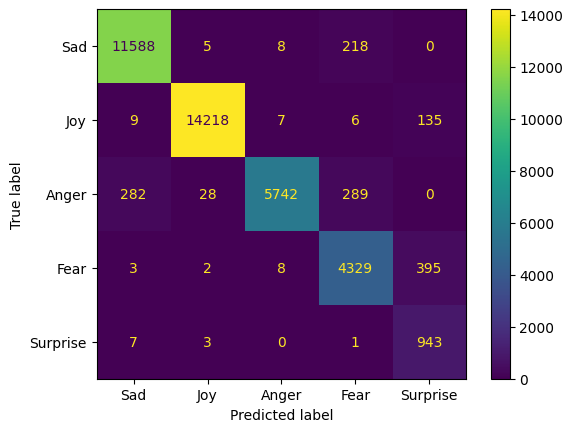

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay

cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sad', 'Joy', 'Anger', 'Fear','Surprise'])
cm_disp.plot()
plt.show()

In [ ]:
new_texts = (input('Enter your text : '))  # List of new, unseen text samples

new_encodings = loaded_tokenizer(new_texts, truncation=True, padding=True, return_tensors='tf')
new_predictions = loaded_model.predict(dict(new_encodings))
pred = np.argmax(new_predictions.logits, axis=1)
emotion_set = ['Sad', 'Joy', 'Anger', 'Fear','Surprise']
emotion_set[pred[0]]